# Re-Ranking Using Global and Local Features
### UNIVERSITY OF TWENTE

Notebook expanding on the concept of re-ranking through the use of local features and global features along with the fusion of such features. Researchers of this notebook include:
- NIschal Neupane (n.neupane@student.utwente.nl)
- Peshmerge Morad (p.morad@student.utwente.nl)
- Aditya Poozhiyil (adityaretissinpoozhiyil@student.utwente.nl)

## Imports and Dependencies

In [1]:
import os
import re
import sys
import torch
import random
import runpy
import subprocess
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont

import torchvision.transforms as ttf

from torchinfo import summary

# Setup system paths relative to the current file
sys.path.insert(1, os.path.join(os.getcwd(), 'generalized_contrastive_loss', 'labeling'))
sys.path.insert(2, os.path.join(os.getcwd(), 'generalized_contrastive_loss', 'mapillary_sls'))

# Import the other notebook file with models
%run model_notebook.ipynb

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

#### Setup GPU for Cuda

In [2]:
device = torch.device('cpu')
display_devices = True

# If cuda is available...
if torch.cuda.is_available():
    # Find GPU with most free memory and set that as the device
    mem_usage_list = [torch.cuda.mem_get_info(f'cuda:{gpu_num}')[0] for gpu_num in range(torch.cuda.device_count())]
    most_free = mem_usage_list.index(max(mem_usage_list))
    device = torch.device(f'cuda:{most_free}')
    print(f'Setting the device to {device}...\n')

    if display_devices:
        # Print GPU info on all
        for gpu_num in range(torch.cuda.device_count()):
            available_mem, total_mem = torch.cuda.mem_get_info(f'cuda:{gpu_num}')
            print(f'cuda:{gpu_num}')
            print('Memory Usage:')
            print('Total:', round(total_mem/1024**3,2), 'GB')
            print('Allocated:', round((total_mem-available_mem)/1024**3,2), 'GB')
            print('Free:   ', round(available_mem/1024**3,2), 'GB')
            print()
    # Set the default tensor type to gpu
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

Setting the device to cuda:1...

cuda:0
Memory Usage:
Total: 14.56 GB
Allocated: 14.01 GB
Free:    0.54 GB

cuda:1
Memory Usage:
Total: 14.56 GB
Allocated: 0.9 GB
Free:    13.65 GB

cuda:2
Memory Usage:
Total: 14.56 GB
Allocated: 0.9 GB
Free:    13.65 GB

cuda:3
Memory Usage:
Total: 14.56 GB
Allocated: 0.9 GB
Free:    13.65 GB

cuda:4
Memory Usage:
Total: 14.56 GB
Allocated: 0.9 GB
Free:    13.65 GB

cuda:5
Memory Usage:
Total: 14.56 GB
Allocated: 0.9 GB
Free:    13.65 GB

cuda:6
Memory Usage:
Total: 14.56 GB
Allocated: 0.9 GB
Free:    13.65 GB

cuda:7
Memory Usage:
Total: 14.56 GB
Allocated: 0.9 GB
Free:    13.65 GB



#### Set the appropriate environment variables and constants

In [3]:
os.environ['MAPILLARY_ROOT'] = "/home/jovyan/APFIR/generalized_contrastive_loss/mapillary_sls/" # set the mapillary root 
os.environ['LD_LIBRARY_PATH'] = "/opt/miniconda3/lib" # Set the library path to miniconda3

In [4]:
# Indexing Parameters
RE_INDEX = False

# Model Parameters
BACKBONE = "resnext"  # backbone for the model
POOL = "GeM"  # pooling type
NORM = "L2"  # norm type
BATCH_SIZE = 1  # batch size

DILATION = True  # Whether to add dilation layer
FUSION = True  # Whether to use fusion or not

IMG_SIZE = (480, 640)  # Size of input image
PARAM_LENGTH = 2048  # Number of features to generate

 # If we want to apply cross normalization. It's nothing more than applying
 # L2 normalization on the fused features vector 
CROSS_NORMALIZATION = True

In [5]:
# PATHS
MODEL_IMGS = os.path.join(os.getcwd(), "model_imgs")
RESULT_IMGS = os.path.join(os.getcwd(), "result_imgs")
FONT_PATH = os.path.join("DejaVuSans.ttf")

# Check if the model imgs directory exists, if not, create it
if not os.path.exists(MODEL_IMGS):
    os.makedirs(MODEL_IMGS)
# Check if the result imgs directory exists, if not, create it
if not os.path.exists(RESULT_IMGS):
    os.makedirs(RESULT_IMGS)

DATA_ROOT = os.path.join(os.getcwd(), "generalized_contrastive_loss")

MSLS_MODELS = os.path.join(DATA_ROOT, "Models", "MSLS")
RESULTS_ROOT = os.path.join(DATA_ROOT, "results", "MSLS", "val")
PREDICTION_PATH = os.path.join(RESULTS_ROOT, "MSLS_resnext_GeM_480_GCL_predictions.txt")

MODEL_WEIGHT_NAME = "MSLS_resnext_GeM_480_GCL"
MODEL_WEIGHTS = os.path.join(MSLS_MODELS, f"{MODEL_WEIGHT_NAME}.pth")

DATASET_ROOT = os.path.join(DATA_ROOT, "msls")
DATASET_TEST = os.path.join(DATASET_ROOT, "test")
DATASET_VAL = os.path.join(DATASET_ROOT, "train_val")

DATASET_VAL_SF = os.path.join(DATASET_VAL, "sf")
DATASET_VAL_CPH = os.path.join(DATASET_VAL, "cph")

model_format = MODEL_WEIGHT_NAME
global_feat_format = MODEL_WEIGHT_NAME+"_{city}"
local_feat_format = MODEL_WEIGHT_NAME+"_{city}"
results_format = MODEL_WEIGHT_NAME
if DILATION:
    local_feat_format += "_dilation"
    results_format += "_dilation"
    model_format += "_dilation"
if NORM:
    global_feat_format += f"_{NORM}"
    local_feat_format += f"_{NORM}"
    results_format += f"_{NORM}"
    model_format += f"_{NORM}"
if FUSION:
    results_format += "_fusion"
global_feat_format += "_global_{db}feats.npy"
local_feat_format += "_local_{db}feats.npy"
results_format += "_results.txt"
model_format += "_{ftype}.png"

----
----

## Helper Functions
Small function defined to help with code.

In [6]:
# Function that allows you to convert a given list of string into an image
def text2png(lines, fullpath, color="#000", bgcolor="#FFF", fontfullpath=None,
             fontsize=13, leftpadding=3, rightpadding=3, width=200):
    font = ImageFont.truetype(fontfullpath, fontsize) if fontfullpath else ImageFont.truetype("arial.ttf", fontsize)

    line_height = fontsize
    img_height = line_height * (len(lines) + (len(lines)//2))

    img = Image.new("RGBA", (width, img_height), bgcolor)
    draw = ImageDraw.Draw(img)

    x = (width * 0.55)
    y = 0
    max_cols = 0
    for line in lines:
        if line:
            if RESULT_IMGS in fullpath:
                split_text = line.split(":")
                draw.text((leftpadding, y), split_text[0], color, font=font)
                draw.text((leftpadding+x, y), ":", color, font=font)
                draw.text((leftpadding+x+leftpadding, y), split_text[1], color, font=font)
            elif MODEL_IMGS in fullpath:
                split_text = re.split(r'\s{6,}', line)
                num_cols = len(split_text)
                max_cols = max(max_cols, num_cols)
                x = (width // max_cols)
                for col_num, col_text in enumerate(split_text):
                    draw.text((leftpadding+(col_num*x), y), col_text, color, font=font)
            else:
                draw.text((leftpadding, y), line, color, font=font)
        y += line_height + (line_height//2)

    img.save(fullpath, dpi=(600, 600))

----
----

## Indexing Dataset
Create the json indicies of the images, same as running the following command:
> python3 labeling/create_json_idx.py --dataset msls --root_dir "/home/jovyan/APFIR/generalized_contrastive_loss/msls/"

In [7]:
# Pre-check for creating indicies
def generateIndicies(replace=False):
    if not replace:
        for city_dir in os.listdir(DATASET_VAL):
            if city_dir == ".DS_Store": continue
            # get the files and check if query.json and database.json are in there
            if all(elem in os.listdir(os.path.join(DATASET_VAL, city_dir)) for elem in ['query.json', 'database.json']):
                print(f"Json index present for {city_dir}.")
                continue
            else:
                print(f"Could not find json index for {city_dir}. Creating all label indicies.")
                break
        return
    print('Indexing the data...')
    if "--dataset" not in sys.argv:
        sys.argv = [sys.argv[0]]
        sys.argv.extend(["--dataset", "msls", "--root_dir", os.path.join(os.getcwd(), DATASET_ROOT)])
    runpy.run_module('create_json_idx', run_name='__main__')
    print('Done indexing data.')


# Generates indicies if needed
generateIndicies(replace=RE_INDEX)

Json index present for sf.
Json index present for austin.
Json index present for boston.
Json index present for budapest.
Json index present for nairobi.
Json index present for cph.
Json index present for saopaulo.
Json index present for tokyo.
Json index present for helsinki.
Json index present for toronto.
Json index present for zurich.
Json index present for manila.
Json index present for london.
Json index present for phoenix.
Json index present for amsterdam.
Json index present for moscow.
Json index present for ottawa.
Json index present for amman.
Json index present for berlin.
Json index present for melbourne.
Json index present for goa.
Json index present for paris.
Json index present for trondheim.
Json index present for bangkok.


----
----

## Feature Extraction
Section regarding local and global feature extraction depending on the necessity. The extracted features are saved in results.

#### Helper Functions Defintion
All helper functions listed for feature extraction and other aspects of feature extraction.

##### Helper Function #1: Extract Features to File
These functions extract the features of the msls dataset into the respective files.

In [8]:
def extract_features_to_file(dataloader, model, f_length, feature_filepath, device):
    if not os.path.exists(feature_filepath):
        # pre-allocate memory for features
        feats = torch.empty((len(dataloader.dataset), f_length), device=device)

        with torch.no_grad():
            for i, batch in tqdm(enumerate(dataloader), desc="Extracting features for "+feature_filepath):
                x = model(batch.to(device)).squeeze(-1).squeeze(-1)
                feats[i * dataloader.batch_size:i * dataloader.batch_size + dataloader.batch_size] = x

        # move features to CPU and save to file
        feats = feats.cpu().numpy()
        np.save(feature_filepath, feats)
        print(f"{feature_filepath} has been saved.")
    else:
        print(feature_filepath, "already exists. Skipping.")

##### Helper Function #2: Extract Features
These functions extract the features of the msls dataset. Depending on the necessity, there are two helper functions, one for local feature extraction and another for global feature extraction.

In [9]:
def extract_features(model, feat_format, f_length, device):
    # Get all the cities in the validation set
    cities = default_cities["val"]

    # Create a transformation for each image in the dataloader
    image_transform = ttf.Compose([
        ttf.Resize(size=(IMG_SIZE[0], IMG_SIZE[1])),
        ttf.ToTensor(),
        ttf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Loop through each city to create specific features for each
    for city in cities:
        print(city)
        query_idx = os.path.join(DATASET_ROOT, "train_val", city, "query.json")
        map_idx = os.path.join(DATASET_ROOT, "train_val", city, "database.json")

        q_dataloader = create_dataloader("test", DATASET_ROOT, query_idx, None, image_transform, BATCH_SIZE)
        q_feature_filepath = os.path.join(RESULTS_ROOT, feat_format.format(city=city, db="query"))
        extract_features_to_file(q_dataloader, model, f_length, q_feature_filepath, device)

        m_dataloader = create_dataloader("test", DATASET_ROOT, map_idx, None, image_transform, BATCH_SIZE)
        m_feature_filepath = os.path.join(RESULTS_ROOT, feat_format.format(city=city, db="map"))
        extract_features_to_file(m_dataloader, model, f_length, m_feature_filepath, device)

-------

#### Create the Model and Load Weights
Create the model from the given backend and load the weights of the model.

In [11]:
# Create the models
model = create_model(BACKBONE, POOL, norm=NORM, mode="single").to(device)

# Load the weights
try:
    model.load_state_dict(torch.load(MODEL_WEIGHTS)["model_state_dict"])
except:
    model.load_state_dict(torch.load(MODEL_WEIGHTS)["state_dict"])

if torch.cuda.is_available():
    model.cuda()

# Set model to inference mode
model.eval()
print('Model loaded!')

Using cache found in /home/jovyan/.cache/torch/hub/facebookresearch_WSL-Images_main


 the layers of the resnext101_32x8d_wsl are: odict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])
 the layers of the resnext101_32x8d_wsl are after removing the last two layers (avgpool and fc): odict_keys(['0', '1', '2', '3', '4', '5', '6', '7'])
Number of layers: 8
0 Conv2d IS TRAINED
1 BatchNorm2d IS TRAINED
2 ReLU IS TRAINED
3 MaxPool2d IS TRAINED
4 Sequential IS TRAINED
5 Sequential IS TRAINED
6 Sequential IS TRAINED
7 Sequential IS TRAINED
Model loaded!


----

#### Generate Features
Function to generate features and create the individual models.

In [12]:
def generateFeatures(global_feat_model, input_size, hidden_dim, output_dim,
                     feature_types, norm, dilation, generate_summary, device,
                     globalfeat_format, localfeat_format):
    # Create the local feature model by removing the last layer and the pooling
    # local_feat_model = torch.nn.Sequential(*(list(list(global_feat_model.children())[0].children ())[:-1]), list(global_feat_model.children())[1])
    local_feat_model = torch.nn.Sequential(*(list(list(global_feat_model.children())[0].children())[:-1]))

    # global_feat_model = torch.nn.Sequential(*(list(local_feat_model.children())), list(list(global_feat_model.children())[0].children ())[-1], list(global_feat_model.children())[1])
    global_feat_model = torch.nn.Sequential(*(list(list(global_feat_model.children())[0].children())), list(global_feat_model.children())[1]).to(device)

    # Create the local branch and add the layers together
    local_branch = LocalBranch(input_dim=hidden_dim, out_channel=output_dim, norm=norm, dilation=dilation, image_size=IMG_SIZE)
    local_branch.cuda() # move the local branch to cuda as well
    local_feat_model = torch.nn.Sequential(*(list(local_feat_model.children())), *(list(local_branch.children()))).to(device)

    # Columns to show for model summary
    cols = ("input_size", "output_size", "num_params", "trainable")

    if not os.path.exists(RESULTS_ROOT):
        os.makedirs(RESULTS_ROOT)

    if feature_types == "both":
        # generate both features
        # first, generate local features
        extract_features(
            global_feat_model,
            feat_format=localfeat_format,
            f_length=output_dim,
            device=device
        )
        # then, generate global features
        extract_features(
            global_feat_model,
            feat_format=globalfeat_format,
            f_length=output_dim,
            device=device
        )
        if generate_summary:
            print("SUMMARY OF LOCAL FEATURE MODEL:")
            local_model_stats = summary(local_feat_model, input_size = input_size, col_names = cols, verbose = 1, depth=2)
            # Save the model summary as an image
            text2png(lines=str(local_model_stats).split("\n")[1:],
                     fullpath=os.path.join(MODEL_IMGS, model_format.format(ftype="local")),
                     fontfullpath=FONT_PATH,
                     fontsize=13,
                     leftpadding=5,
                     rightpadding=5,
                     width=250*len(cols)
                    )

            print("\n\nSUMMARY OF GLOBAL FEATURE MODEL:")
            global_model_stats = summary(global_feat_model, input_size = input_size, col_names = cols, verbose = 1, depth=2)
            # Save the model summary as an image
            text2png(lines=str(global_model_stats).split("\n")[1:],
                     fullpath=os.path.join(MODEL_IMGS, model_format.format(ftype="global").replace("_dilation", "")),
                     fontfullpath=FONT_PATH,
                     fontsize=13,
                     leftpadding=5,
                     rightpadding=5,
                     width=250*len(cols)
                    )
    elif feature_types == "global":
        # generate only global features
        extract_features(
            global_feat_model,
            feat_format=globalfeat_format,
            f_length=output_dim,
            device=device
        )
        if generate_summary:
            print("SUMMARY OF LOCAL FEATURE MODEL:")
            local_model_stats = summary(global_feat_model, input_size = input_size, col_names = cols, verbose = 1, depth=2)
            # Save the model summary as an image
            text2png(lines=str(local_model_stats).split("\n")[1:],
                     fullpath=os.path.join(MODEL_IMGS, model_format.format(ftype="local")),
                     fontfullpath=FONT_PATH,
                     fontsize=13,
                     leftpadding=5,
                     rightpadding=5,
                     width=250*len(cols)
                    )
    else:
        # generate only local features
        extract_features(
            global_feat_model,
            feat_format=localfeat_format,
            f_length=output_dim,
            device=device
        )
        if generate_summary:
            print("SUMMARY OF LOCAL FEATURE MODEL:")
            global_model_stats = summary(local_feat_model, input_size = input_size, col_names = cols, verbose = 1, depth=2)
            # Save the model summary as an image
            text2png(lines=str(global_model_stats).split("\n")[1:],
                     fullpath=os.path.join(MODEL_IMGS, model_format.format(ftype="global").replace("_dilation", "")),
                     fontfullpath=FONT_PATH,
                     fontsize=13,
                     leftpadding=5,
                     rightpadding=5,
                     width=250*len(cols)
                    )


generateFeatures(
    model,
    input_size=(BATCH_SIZE, 3, 480, 640),
    hidden_dim=1024,
    output_dim=2048,
    feature_types="both",
    norm=NORM,
    dilation=DILATION,
    globalfeat_format=global_feat_format,
    localfeat_format=local_feat_format,
    generate_summary=False,
    device=device
)

cph
/home/jovyan/APFIR/generalized_contrastive_loss/results/MSLS/val/MSLS_resnext_GeM_480_GCL_cph_dilation_L2_local_queryfeats.npy already exists. Skipping.
/home/jovyan/APFIR/generalized_contrastive_loss/results/MSLS/val/MSLS_resnext_GeM_480_GCL_cph_dilation_L2_local_mapfeats.npy already exists. Skipping.
sf
/home/jovyan/APFIR/generalized_contrastive_loss/results/MSLS/val/MSLS_resnext_GeM_480_GCL_sf_dilation_L2_local_queryfeats.npy already exists. Skipping.
/home/jovyan/APFIR/generalized_contrastive_loss/results/MSLS/val/MSLS_resnext_GeM_480_GCL_sf_dilation_L2_local_mapfeats.npy already exists. Skipping.
cph
/home/jovyan/APFIR/generalized_contrastive_loss/results/MSLS/val/MSLS_resnext_GeM_480_GCL_cph_L2_global_queryfeats.npy already exists. Skipping.
/home/jovyan/APFIR/generalized_contrastive_loss/results/MSLS/val/MSLS_resnext_GeM_480_GCL_cph_L2_global_mapfeats.npy already exists. Skipping.
sf
/home/jovyan/APFIR/generalized_contrastive_loss/results/MSLS/val/MSLS_resnext_GeM_480_GCL_sf

----
----

## Re-Ranking
Particular section dedicated to fusion and re-ranking methods.

In [13]:
# Run the rerank notebook
%run rerank.ipynb

### Fusion
First, we define the fusion methods for the re-ranking part.

##### Orthogonal Fusion
A method of fusion that uses vector projection to project local features onto the global features and then concatenates them. (Written as a nn module fully-connected layer)

In [14]:
class OrthogonalFusion(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, local_feat, global_feat):
        global_feat_norm = torch.norm(global_feat, p=2, dim=1, keepdim=True)
        projection = torch.bmm(global_feat.unsqueeze(1), torch.flatten(local_feat, start_dim=1).unsqueeze(2))
        projection = torch.bmm(global_feat.unsqueeze(2), projection).view(local_feat.size())
        projection = projection / (global_feat_norm * global_feat_norm)
        orthogonal_comp = local_feat - projection
        return torch.cat([global_feat, orthogonal_comp], dim=1)

##### Hadamard Fusion
A method of fusion that simply does a Hadamard vector multiplication.

In [15]:
def hadamard_fusion(global_features, local_features):
    """when you apply just the sequeeze() it removes all the ones
    #so (1,2048,1,1) after squeezing -> (2048), adding that extra dimension on the zero 
    #axis :- unsqueeze(0) (1,2048)"""
    if global_features.shape[0] == 1:
        x = np.multiply(local_features, global_features).squeeze().unsqueeze(0)
    else:
        # if we have batch size!=1, then we dont have to unsqueeze because
        # it wont squeeze the batch size hadamard product
        x = np.multiply(local_features, global_features).squeeze()
    return x

----

### Re-Ranking
Setting up configuration and re-ranking the results.

In [16]:
# Configuration to be passed for re-ranking
configuration = {
    "cities": ["cph", "sf"],
    "prediction_path": PREDICTION_PATH,
    "features_path": RESULTS_ROOT,
    "local_feat_format": local_feat_format,
    "global_feat_format": global_feat_format,
    "results_file_format": results_format,
    "fusion": FUSION,
    "data_path": DATASET_VAL,
    "similarity_measure": torch.cdist,
    "fusion_method": OrthogonalFusion(),
    "cross_normalization": CROSS_NORMALIZATION
}

In [20]:
%run rerank.ipynb

In [21]:
%%time
# Re-rank and return the dataframe and the result file location
reranked_df, configuration, saved_results_file = rank(configuration, device)

Ranking for sf: 100%|██████████| 4525/4525 [00:03<00:00, 1281.37it/s]


Writing the results to /home/jovyan/APFIR/generalized_contrastive_loss/results/MSLS/val/MSLS_resnext_GeM_480_GCL_dilation_L2_fusion_results.txt.
CPU times: user 1min 30s, sys: 7.96 s, total: 1min 38s
Wall time: 9.81 s


----
----

## Evaluation
Use the MSLS evaluation server to evaluate the results of the re-ranking.

In [22]:
# Evaluation command with required paths
command = ["python", os.path.join(os.getcwd(), 'generalized_contrastive_loss', 'mapillary_sls', 'evaluate.py'), "--prediction", saved_results_file, "--msls-root", DATASET_ROOT, "--cities", "cph,sf"]
print("Running evaluation...")
# Run the evaluation and wait for completion
result = subprocess.run(command, capture_output=True, text=True)
print("Finished running evaluation.")

Running evaluation...
Finished running evaluation.


In [23]:
# Setup the strings to be printed out for evaluation information

eval_result = []
# Add information about the parameters
eval_result.append(f"FUSION: {FUSION}")  # Whether it is fusion or not
eval_result.append(f"BACKBONE: {BACKBONE}")  # backbone for the model
eval_result.append(f"POOL: {POOL}")  # pooling type
eval_result.append(f"NORM: {NORM}")  # norm type
eval_result.append(f"DILATION: {DILATION}")  # Whether to add dilation layer
eval_result.append("")  # Empty line for asthetics

# Get the eval results only
eval_result.extend(result.stdout.split('\n')[-9:-1])

# Save the result as an image
text2png(lines=eval_result,
         fullpath=os.path.join(RESULT_IMGS, results_format.replace(".txt", ".png")),
         fontfullpath=FONT_PATH,
         fontsize=13,
         leftpadding=5,
         rightpadding=5
        )

----
----

## Further Analysis
Performing further analysis on the topic including error analysis.

In [106]:
%run further_analysis.ipynb

### Visual Analysis
Visually analyze the images, the difference and the retrievals as well as re-ranking.

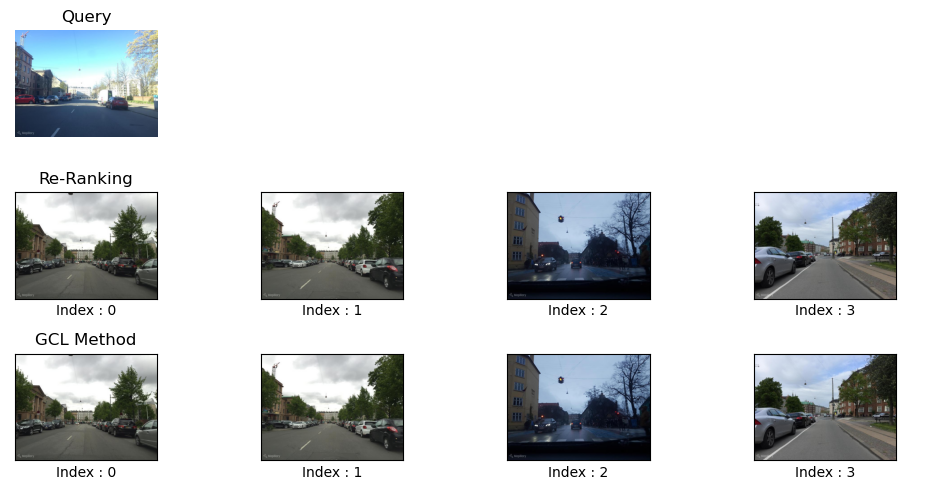

In [107]:
plot_image(1, reranked_df, "cph", configuration, 4)

----
----

## Extra

In [ ]:
# from pyheat import PyHeat

In [ ]:
# ph = PyHeat("test.py")
# ph.create_heatmap()
# mytest.main(["-x","7","-y","6"])